# Introductory Analysis


In [1]:
from pathlib import *
import sqlalchemy as sa
import numpy as np
import pandas as pd
import axelrod as axl
import nashpy as nash
import matplotlib.pyplot as plt
import axelrod as axl
from datetime import date
from pandas.plotting import table
%matplotlib inline

Size of Database as of writing: 

In [3]:
today_date = date.today().strftime("%d_%m_%Y")
database_management_sys = sa.create_engine("sqlite:///../database_code/data/se/main.db")
connect_dbms_to_db = database_management_sys.connect()
se_folk_thm_data = pd.read_sql("folk_theorem_experiment", connect_dbms_to_db)

database_size_path = Path("../database-code/data/se/" + today_date + "/")
database_size_path.mkdir(parents=True, exist_ok=True)
p = database_size_path / "entries-in-database.txt"
q = database_size_path / "number-of-tournaments.txt"
with open(str(p), "w") as num_of_entries_file:
    num_of_entries_file.write(str(len(se_folk_thm_data)))
with open(str(q), "w") as num_of_tournaments_file:
    num_of_tournaments_file.write(str(max(se_folk_thm_data["tournament_player_set"])))
len(se_folk_thm_data), max(se_folk_thm_data["tournament_player_set"])


(825700, 159)

In [4]:
se_folk_thm_data.head()


,experiment_number,number_of_players,tournament_player_set,player_strategy_name,is_long_run_time,is_stochastic,memory_depth_of_strategy,prob_of_game_ending,payoff_matrix,num_of_repetitions,num_of_equilibria,nash_equilibria,least_prob_of_defection,greatest_prob_of_defection,noise,warning_message
0,0,2,0,Inverse,False,True,Inf,0.001000,3. 0.99159429 1.03362284 1.,500,3.0,1. 0. 1. 0. ...,0.0,1.0,0.0,None
1,0,2,0,Defector,False,False,0,0.001000,3. 0.99159429 1.03362284 1.,500,3.0,1. 0. 1. 0. ...,0.0,1.0,0.0,None
2,1,2,0,Inverse,False,True,Inf,0.011081,3. 0.95530245 1.1787902 1.,500,3.0,1. 0. 1. 0. ...,0.0,1.0,0.0,None
3,1,2,0,Defector,False,False,0,0.011081,3. 0.95530245 1.1787902 1.,500,3.0,1. 0. 1. 0. ...,0.0,1.0,0.0,None
4,2,2,0,Inverse,False,True,Inf,0.021162,3. 0.9212484 1.31500641 1.,500,3.0,1. 0. 1. 0. ...,0.0,1.0,0.0,None


### Summary Statistics


In [5]:
summary_stats_path = Path("../../images/folk_thm/initial_analysis/")
summary_stats_path.mkdir(parents=True, exist_ok=True)
summary_stats = (
    se_folk_thm_data.describe()
    .drop("count")
    .drop(["prob_of_game_ending", "noise", "num_of_repetitions"], axis=1)
)
p = summary_stats_path / "summary_stats.tex"
table_tex = summary_stats.to_latex(buf=str(p),)


TypeError: to_latex() got an unexpected keyword argument 'caption'

The average number of players per tournament in the experiment is 5 players.

The probabilities of the game ending is centred around p = 0.5.

The average number of Nash equilibria calculated from the payoff matrices is 2, with the majority of games having 1 - 3 equilibria. However, what is interesting here is that at least one game obtained 39 equilibria (as can be seen from the table above). A further search regarding this will be executed later.

The mean for the least probability of defection in any one game is 0.342275 and for the greatest probability of defection it is 0.459722. However, both probabilities have yielded a value of 0 and 1 over the experiment. 

### Strategy Statistics


In [6]:
strategy_data = se_folk_thm_data[
    [
        "tournament_player_set",
        "player_strategy_name",
        "is_stochastic",
        "is_long_run_time",
        "memory_depth_of_strategy",
    ]
].drop_duplicates()
strategy_data.head()


,tournament_player_set,player_strategy_name,is_stochastic,is_long_run_time,memory_depth_of_strategy
0,0,Inverse,True,False,Inf
1,0,Defector,False,False,0
2200,1,ALLCorALLD,True,False,1
2201,1,Defector,False,False,0
4400,2,Handshake,False,False,Inf


In [7]:
strategy_counts = strategy_data["player_strategy_name"].value_counts()
strategy_counts.head(), strategy_counts.tail()


(Defector                             160
 ZD-GEN-2: 0.125, 0.5, 3                9
 Tideman and Chieruzzi                  8
 General Soft Grudger: n=1,d=4,c=2      7
 ZD-GTFT-2: 0.25, 0.5                   7
 Name: player_strategy_name, dtype: int64,
 Gradual Killer: (D, D, D, D, D, C, C)    1
 AdaptorLong                              1
 Tricky Defector                          1
 Suspicious Tit For Tat                   1
 MoreGrofman                              1
 Name: player_strategy_name, dtype: int64)

In [8]:
len(strategy_counts[strategy_counts == 1]), len(
    strategy_data["player_strategy_name"].drop_duplicates()
)


(38, 200)

Excluding the defector, the strategy which appeared the most (9 times) is ZD-GEN-2: 0.125, 0.5, 3; followed closely by Tideman and Chieruzzi with 7 times. On the other hand 38 out of the 200 strategies executed in this experiment appeared only once. Next, these counts will be plotted with regards to the players characteristics to see if there is any overarching bias that needs to be taken into account.

In [9]:
strategy_data["is_stochastic"].value_counts()


False    551
True     204
Name: is_stochastic, dtype: int64

In [10]:
strategy_data["is_long_run_time"].value_counts()


False    755
Name: is_long_run_time, dtype: int64

In [11]:
strategy_data["memory_depth_of_strategy"].value_counts()


Inf    366
0      166
1      104
2       35
5       26
3       22
10      11
200      6
11       4
6        4
40       3
20       3
4        2
12       2
8        1
Name: memory_depth_of_strategy, dtype: int64

The majority of strategies participating in this experiment had either an infinite, one or no memory depth.

In [12]:
strategy_counts_no_defect = strategy_counts.drop("Defector")
strategy_counts_no_defect.head(), len(strategy_counts_no_defect)


(ZD-GEN-2: 0.125, 0.5, 3              9
 Tideman and Chieruzzi                8
 General Soft Grudger: n=1,d=4,c=2    7
 ZD-GTFT-2: 0.25, 0.5                 7
 Cycler DC                            7
 Name: player_strategy_name, dtype: int64, 199)

In [13]:
labels = []
for player in strategy_counts_no_defect.index:
    stochastic_player = pd.Series(
        strategy_data[strategy_data["player_strategy_name"] == player]["is_stochastic"]
    )
    stochastic_player.index = range(len(stochastic_player))
    stochastic_player = stochastic_player[0]
    labels.append(stochastic_player)


In [14]:
len(labels)


199

In [15]:
player_stochastic_dict = {
    "player_strategy_name": strategy_counts_no_defect.index,
    "strategy_counts": strategy_counts_no_defect.values,
    "is_stochastic": labels,
}

player_stochastic_data = pd.DataFrame(player_stochastic_dict)


In [16]:
player_stochastic_data.head()


,player_strategy_name,strategy_counts,is_stochastic
0,"ZD-GEN-2: 0.125, 0.5, 3",9,True
1,Tideman and Chieruzzi,8,False
2,"General Soft Grudger: n=1,d=4,c=2",7,False
3,"ZD-GTFT-2: 0.25, 0.5",7,True
4,Cycler DC,7,False


In [18]:
stochastic_player_data = player_stochastic_data[
    player_stochastic_data["is_stochastic"] == True
]
deterministic_player_data = player_stochastic_data[
    player_stochastic_data["is_stochastic"] == False
]
stochastic_player_data.head(), deterministic_player_data.head()


(                  player_strategy_name  strategy_counts  is_stochastic
 0              ZD-GEN-2: 0.125, 0.5, 3                9           True
 3                 ZD-GTFT-2: 0.25, 0.5                7           True
 5                            Joss: 0.9                6           True
 7                  Feld: 1.0, 0.5, 200                6           True
 12  Meta Winner Memory One: 34 players                6           True,
                 player_strategy_name  strategy_counts  is_stochastic
 1              Tideman and Chieruzzi                8          False
 2  General Soft Grudger: n=1,d=4,c=2                7          False
 4                          Cycler DC                7          False
 6             Meta Hunter: 6 players                6          False
 8                          Fortress3                6          False)

In [19]:
len(stochastic_player_data[stochastic_player_data["strategy_counts"] == 2])


22

In [20]:
len(axl.filtered_strategies(filterset={"stochastic": True})), len(
    axl.filtered_strategies(filterset={"stochastic": False})
)


(86, 156)

### Number of Nash Equilibria


In [20]:
nash_equilibria_data = se_folk_thm_data[
    [
        "experiment_number",
        "number_of_players",
        "prob_of_game_ending",
        "num_of_equilibria",
        "nash_equilibria",
    ]
].drop_duplicates()
len(nash_equilibria_data)


175400

In [21]:
nash_equilibria_data_no_nas = (
    se_folk_thm_data[
        [
            "experiment_number",
            "number_of_players",
            "prob_of_game_ending",
            "num_of_equilibria",
            "nash_equilibria",
        ]
    ]
    .drop_duplicates()
    .dropna()
)
len(nash_equilibria_data_no_nas)


175107

In [22]:
nash_equilibria_data_no_nas["num_of_equilibria"].value_counts()


1.0     131773
3.0      28793
5.0       4761
4.0       3333
7.0       2215
9.0       1123
2.0        923
6.0        643
11.0       439
8.0        190
10.0       166
13.0       163
15.0        99
17.0        87
16.0        80
18.0        70
12.0        58
14.0        51
25.0        45
19.0        30
21.0        16
23.0        10
27.0         9
20.0         7
37.0         5
38.0         5
26.0         3
31.0         3
35.0         2
22.0         2
29.0         2
39.0         1
Name: num_of_equilibria, dtype: int64

In [23]:
game_with_max_eq = se_folk_thm_data[se_folk_thm_data["num_of_equilibria"] == 39]
game_with_max_eq.index = range(len(game_with_max_eq))
game_with_max_eq


,experiment_number,number_of_players,tournament_player_set,player_strategy_name,is_long_run_time,is_stochastic,memory_depth_of_strategy,prob_of_game_ending,payoff_matrix,num_of_repetitions,num_of_equilibria,nash_equilibria,least_prob_of_defection,greatest_prob_of_defection,noise,warning_message
0,120004,6,109,Inverse Punisher,False,False,Inf,0.041323,2.0132713 1.96208203 2.48978222 1.7417925...,500,39.0,1. 0. 0. 0. ...,0.0,1.0,0.1,None
1,120004,6,109,Prober,False,False,Inf,0.041323,2.0132713 1.96208203 2.48978222 1.7417925...,500,39.0,1. 0. 0. 0. ...,0.0,1.0,0.1,None
2,120004,6,109,PSO Gambler 2_2_2 Noise 05,False,True,Inf,0.041323,2.0132713 1.96208203 2.48978222 1.7417925...,500,39.0,1. 0. 0. 0. ...,0.0,1.0,0.1,None
3,120004,6,109,Handshake,False,False,Inf,0.041323,2.0132713 1.96208203 2.48978222 1.7417925...,500,39.0,1. 0. 0. 0. ...,0.0,1.0,0.1,None
4,120004,6,109,More Tideman and Chieruzzi,False,False,Inf,0.041323,2.0132713 1.96208203 2.48978222 1.7417925...,500,39.0,1. 0. 0. 0. ...,0.0,1.0,0.1,None
5,120004,6,109,Defector,False,False,0,0.041323,2.0132713 1.96208203 2.48978222 1.7417925...,500,39.0,1. 0. 0. 0. ...,0.0,1.0,0.1,None


In [24]:
separated_player_dict = {}
for player_number in nash_equilibria_data_no_nas["number_of_players"].drop_duplicates():
    separated_player_dict[str(player_number)] = nash_equilibria_data_no_nas[
        nash_equilibria_data_no_nas["number_of_players"] == player_number
    ]["num_of_equilibria"]
separated_player_dict.keys()


dict_keys(['2', '3', '4', '5', '6', '7', '8'])

In [25]:
for key in separated_player_dict.keys():
    separated_player_dict[key].index = range(len(separated_player_dict[key]))
separated_player_dict.values()


dict_values([0        3.0
1        3.0
2        3.0
3        3.0
4        3.0
        ... 
27495    4.0
27496    4.0
27497    4.0
27498    4.0
27499    4.0
Name: num_of_equilibria, Length: 27500, dtype: float64, 0        6.0
1        6.0
2        6.0
3        6.0
4        6.0
        ... 
27495    1.0
27496    1.0
27497    1.0
27498    1.0
27499    1.0
Name: num_of_equilibria, Length: 27500, dtype: float64, 0        11.0
1        11.0
2        10.0
3        11.0
4        11.0
         ... 
27481     1.0
27482     1.0
27483     1.0
27484     1.0
27485     2.0
Name: num_of_equilibria, Length: 27486, dtype: float64, 0        11.0
1        10.0
2        10.0
3         6.0
4         6.0
         ... 
27452     1.0
27453     1.0
27454     4.0
27455     4.0
27456     4.0
Name: num_of_equilibria, Length: 27457, dtype: float64, 0        18.0
1        15.0
2        16.0
3        13.0
4        16.0
         ... 
27437     1.0
27438     3.0
27439     3.0
27440    11.0
27441    10.0
Name: num_of_eq

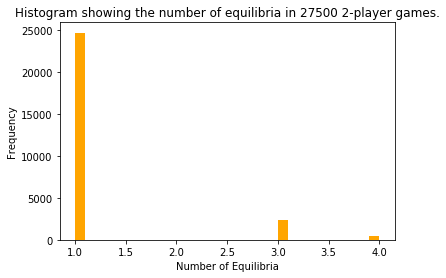

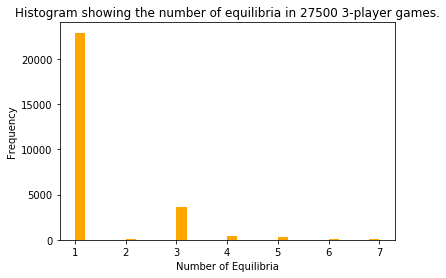

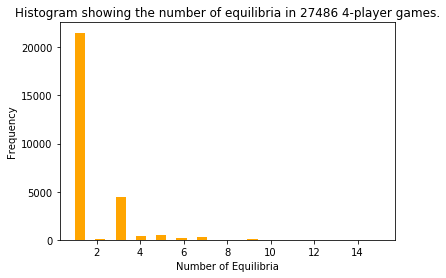

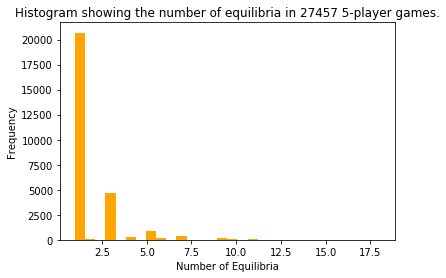

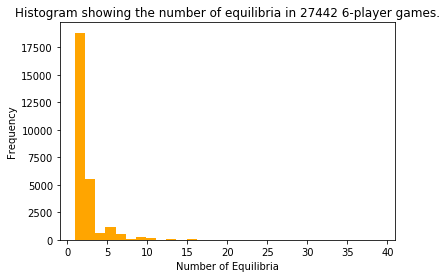

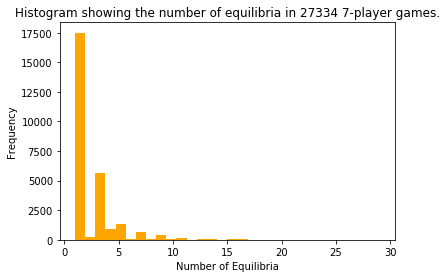

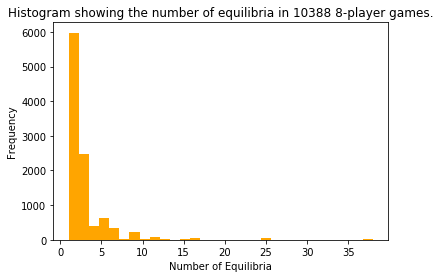

In [26]:
for num_of_players in separated_player_dict.keys():
    histogram_file_name = (
        "number_of_equilibria_histogram_" + str(num_of_players) + "_players.pdf"
    )
    histogram_plot_path = summary_stats_path / histogram_file_name
    histograms = plt.figure()
    axes = histograms.add_subplot(1, 1, 1)
    axes.set_xlabel("Number of Equilibria")
    axes.set_ylabel("Frequency")
    axes.set_title(
        "Histogram showing the number of equilibria in "
        + str(len(separated_player_dict[str(num_of_players)]))
        + " "
        + str(num_of_players)
        + "-player games."
    )
    axes.hist(
        separated_player_dict[str(num_of_players)], bins=30, color="orange",
    )
    histograms.savefig(str(histogram_plot_path))


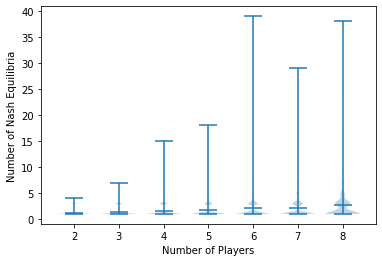

In [91]:
player_num_of_equilibria_violin_path = (
    summary_stats_path / "player_num_of_equilibria_violinplot.pdf"
)
player_num_of_equilibria_violinplot = plt.figure()
axes = player_num_of_equilibria_violinplot.add_subplot(1, 1, 1)
axes.set_xlabel("Number of Players")
axes.set_xticks(np.arange(1, len(range(7)) + 1))
axes.set_xticklabels(list(range(2, 9)))
axes.set_ylabel("Number of Nash Equilibria")
axes.violinplot(
    separated_player_dict.values(), widths=0.8, showextrema=False,
)
axes.boxplot(data, positions=[pos], sym="")
player_num_of_equilibria_violinplot.savefig(str(player_num_of_equilibria_violin_path))


In [27]:
se_folk_thm_data.head()


,experiment_number,number_of_players,tournament_player_set,player_strategy_name,is_long_run_time,is_stochastic,memory_depth_of_strategy,prob_of_game_ending,payoff_matrix,num_of_repetitions,num_of_equilibria,nash_equilibria,least_prob_of_defection,greatest_prob_of_defection,noise,warning_message
0,0,2,0,Inverse,False,True,Inf,0.001000,3. 0.99159429 1.03362284 1.,500,3.0,1. 0. 1. 0. ...,0.0,1.0,0.0,None
1,0,2,0,Defector,False,False,0,0.001000,3. 0.99159429 1.03362284 1.,500,3.0,1. 0. 1. 0. ...,0.0,1.0,0.0,None
2,1,2,0,Inverse,False,True,Inf,0.011081,3. 0.95530245 1.1787902 1.,500,3.0,1. 0. 1. 0. ...,0.0,1.0,0.0,None
3,1,2,0,Defector,False,False,0,0.011081,3. 0.95530245 1.1787902 1.,500,3.0,1. 0. 1. 0. ...,0.0,1.0,0.0,None
4,2,2,0,Inverse,False,True,Inf,0.021162,3. 0.9212484 1.31500641 1.,500,3.0,1. 0. 1. 0. ...,0.0,1.0,0.0,None


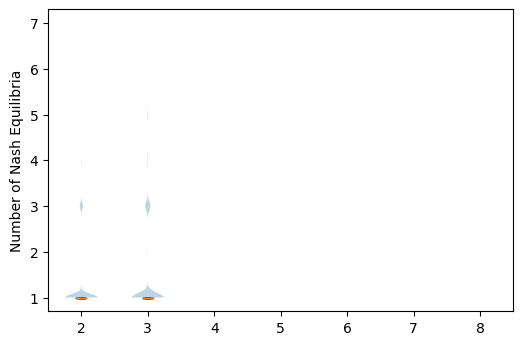

In [32]:
df = se_folk_thm_data

colour = "tab:blue"

file_name = "num_of_eq_violinplot.pdf"
num_of_eq_violinplot_path = summary_stats_path / file_name
fig, ax = plt.subplots(1, dpi=100)
for pos, (num_of_players, data) in enumerate(
    df.groupby("number_of_players")["num_of_equilibria"]
):
    vplot = ax.violinplot(data, positions=[pos], showextrema=False)
    ax.boxplot(data, positions=[pos], sym="")
    for body in vplot["bodies"]:
        body.set_facecolor(colour)

ax.set_xticklabels(df["number_of_players"].unique())
ax.set_ylabel("Number of Nash Equilibria")
plt.savefig(num_of_eq_violinplot_path)
